In [1]:
import pandas as pd
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer
from pathlib import Path
import sys
from imblearn.combine import SMOTEENN
import warnings
from collections import Counter


root_path = Path.cwd().parent  # Set the root path
sys.path.append(str(root_path / 'src'))  # Add the src directory to the system path

# Import the custom Evaluator class
from Evaluator import Evaluator, pr_auc_scorer

# Load the preprocessed data
data_imputed = pd.read_csv('../data/processed/churn_data_imputed.csv')

SEED = 42

In [2]:
# Split the data into train, validation, and test sets (no resampling yet)
X_train, X_temp, y_train, y_temp = train_test_split(
    data_imputed.drop(columns='Exited'), data_imputed['Exited'], test_size=0.4, random_state=SEED, stratify=data_imputed['Exited']
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# Verify class distribution in splits
print("\nClass Distribution Before Resampling:")
print(f"Training set: {Counter(y_train)}")
print(f"Validation set: {Counter(y_valid)}")
print(f"Test set: {Counter(y_test)}")

# Suppress warnings for the following block of code
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

    # Initialize SMOTEENN
    smote_enn = SMOTEENN(random_state=SEED)

    # Resample only the training data
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Verify class distribution after resampling
print("\nClass Distribution After Resampling:")
print(f"Resampled Training set: {Counter(y_train_resampled)}")

# Final dataset shapes
print("\nData Splits and Class Balance After Resampling:")
print(f"Training set: {X_train_resampled.shape}, Class Balance: {y_train_resampled.value_counts(normalize=True).to_dict()}")
print(f"Validation set: {X_valid.shape}, Class Balance: {y_valid.value_counts(normalize=True).to_dict()}")
print(f"Test set: {X_test.shape}, Class Balance: {y_test.value_counts(normalize=True).to_dict()}")



Class Distribution Before Resampling:
Training set: Counter({0.0: 4778, 1.0: 1222})
Validation set: Counter({0.0: 1592, 1.0: 408})
Test set: Counter({0.0: 1593, 1.0: 407})

Class Distribution After Resampling:
Resampled Training set: Counter({1.0: 2139, 0.0: 1705})

Data Splits and Class Balance After Resampling:
Training set: (3844, 11), Class Balance: {1.0: 0.5564516129032258, 0.0: 0.4435483870967742}
Validation set: (2000, 11), Class Balance: {0.0: 0.796, 1.0: 0.204}
Test set: (2000, 11), Class Balance: {0.0: 0.7965, 1.0: 0.2035}


### **Precision-Recall AUC (PR AUC)**

- **When to use**:
  - When the positive class is rare and recall is critical, but precision also matters.
- **Why it's useful**:
  - Focuses on the trade-off between precision and recall rather than overall accuracy.

Why **PR-AUC** is important for us in the context of churn detection?<br>
In churn detection, failing to identify customers who are about to churn (false negatives) can be more costly than incorrectly identifying customers who are not about to churn (false positives). PR-AUC helps in evaluating the trade-off between precision and recall, allowing businesses to prioritize recall (minimizing false negatives) while maintaining acceptable precision.


In [3]:
# Initialize and fit the TPOT classifier
tpot = TPOTClassifier(
    verbosity=1, 
    generations=5, 
    population_size=20, 
    random_state=42, 
    early_stop=4,
    scoring=pr_auc_scorer  # Pass the custom scorer here
)
tpot.fit(X_train, y_train)

# Evaluate the model
print(tpot.score(X_test, y_test))

# Export the best model
tpot.export('best_model.py')


is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


c:\Users\Guill\Miniconda3\envs\tpot\Lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
c:\Users\Guill\Miniconda3\envs\tpot\Lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=4, max_features=0.7000000000000001, min_samples_leaf=12, min_samples_split=9, n_estimators=100, subsample=1.0)
0.6776977981115913


### **Scores**

Accuracy Score	: 0.8705
Precision	: 0.7690
Recall		: 0.5221
F1 Score	: 0.6219
ROC AUC Score	: 0.8832
PR AUC Score	: 0.7324

Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92      1592
         1.0       0.77      0.52      0.62       408

    accuracy                           0.87      2000
   macro avg       0.83      0.74      0.77      2000
weighted avg       0.86      0.87      0.86      2000



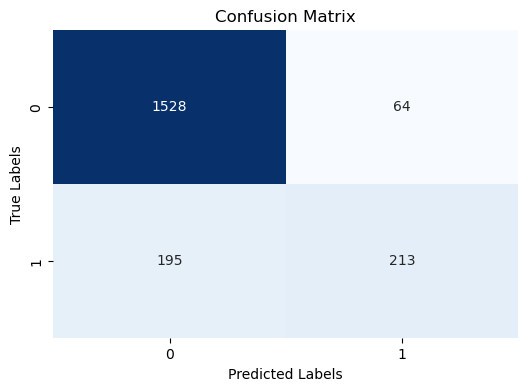

In [4]:
y_pred = tpot.predict(X_valid)

# Initialize the evaluator with predictions
evaluator = Evaluator(y_true=y_valid, y_pred=y_pred, y_proba=tpot.predict_proba(X_valid)[:, 1])

# Display scores
evaluator.display_scores()

# Plot the confusion matrix
evaluator.plot_confusion_matrix()

# Plot the ROC curve
evaluator.roc_curve()

# Plot the PR curve
evaluator.pr_curve()

In [5]:
tpot.export('../models/best_tpot_model.py')
tpot.fitted_pipeline_

Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4,
                                            max_features=0.7000000000000001,
                                            min_samples_leaf=12,
                                            min_samples_split=9,
                                            random_state=42))])

In [6]:
# Store and load the model using joblib (safely store the model)
import joblib

# Save the model
joblib.dump(tpot.fitted_pipeline_, '../models/best_tpot_model.joblib')

# Load the model
loaded_model = joblib.load('../models/best_tpot_model.joblib')